## SALES ANALYSIS ##

**Import the required libraries**

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
import datetime as dt
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import glob
from scipy.stats import skew
from scipy import stats
from sklearn.metrics import (silhouette_score, calinski_harabasz_score,davies_bouldin_score)
import pylab
import scipy

**Reading the data**

In [4]:
path = r"C:\Users\subha\Downloads\Sales data"
csv_files = glob.glob(os.path.join(path, "*.csv"))
list = []
for file_name in csv_files:
    df = pd.read_csv(file_name, index_col= None , header = 0, error_bad_lines= False )
    list.append(df)
df = pd.concat(list, axis = 0, ignore_index= True)
df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"
1,NaN,NaN,NaN,NaN,NaN,NaN
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215"
3,176560,Google Phone,1,600,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186850 entries, 0 to 186849
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Order ID          186305 non-null  object
 1   Product           186305 non-null  object
 2   Quantity Ordered  186305 non-null  object
 3   Price Each        186305 non-null  object
 4   Order Date        186305 non-null  object
 5   Purchase Address  186305 non-null  object
dtypes: object(6)
memory usage: 8.6+ MB


In [6]:
df.describe(include="all")

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
count,186305,186305,186305,186305,186305,186305
unique,178438,20,10,24,142396,140788
top,Order ID,USB-C Charging Cable,1,11.95,Order Date,Purchase Address
freq,355,21903,168552,21903,355,355


In [7]:
#formatting the names of the columns for the given dataframe
for i in df:
    df.columns = df.columns.astype(str)
    df.columns = df.columns.str.strip(" ")
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(" ","_")
df.head()

,order_id,product,quantity_ordered,price_each,order_date,purchase_address
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"
1,NaN,NaN,NaN,NaN,NaN,NaN
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215"
3,176560,Google Phone,1,600,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"


In [8]:
#checking the number and presence of missing values in the main dataframe
df.isna().sum()

order_id            545
product             545
quantity_ordered    545
price_each          545
order_date          545
purchase_address    545
dtype: int64

In [9]:
#trying to understand the meaning of the meaning of missing values in the main dataframe
df_null = df.loc[df['order_id'].isnull()]
df_null.describe(include="all")

,order_id,product,quantity_ordered,price_each,order_date,purchase_address
count,0,0,0,0,0,0
unique,0,0,0,0,0,0
top,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df.order_date.describe()

count         186305
unique        142396
top       Order Date
freq             355
Name: order_date, dtype: object

In [12]:
#cleaning the dates in the dataframe 
df = df.loc[df['order_id'].notnull()]
df = df.loc[df['order_date'].notnull()]
df['order_date'] = pd.to_datetime(df['order_date'], errors = "coerce")

#setting up the datatypes of the columns
df['order_id'] = df['order_id'].astype(int)
df['quantity_ordered'] = df['quantity_ordered'].astype(int)
df['price_each'] = df['price_each'].astype(float)

#creating the month, year, month-year and purchase city columns from the data
df['month'] = pd.DatetimeIndex(df['order_date']).month
df['year'] = pd.DatetimeIndex(df['order_date']).year
df['month_year'] = pd.to_datetime(df['order_date']).apply(lambda x: x.strftime("%B-%Y"))
df['purchase_city'] = df['purchase_address'].apply(lambda x: x.split(",")[1])

#creating the categories of the products
df['category'] = np.where(df['product'].str.contains('Headphones'),"Headphones",
                 np.where(df['product'].str.contains('Cable'),"Cable",
                 np.where(df['product'].str.contains('Batteries'),"Batteries",
                 np.where(df['product'].str.contains('Monitor'),"Monitor",
                 np.where(df['product'].str.contains('Phone'),"Phones",
                 np.where(df['product'].str.contains('TV|Television'),"Television",
                 np.where(df['product'].str.contains('Laptop'),"Laptop",
                 np.where(df['product'].str.contains('Washing|Dryer'),"Washing Machine and Dryers","Others"))))))))

#creating a calculated column for the total sales
df['total_sales'] = round(df['price_each']*df['quantity_ordered'],0)
df.head()

,order_id,product,quantity_ordered,price_each,order_date,purchase_address,month,year,month_year,purchase_city,category,total_sales
0,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",4,2019,April-2019,Dallas,Cable,24.0
2,176559,Bose SoundSport Headphones,1,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",4,2019,April-2019,Boston,Headphones,100.0
3,176560,Google Phone,1,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,2019,April-2019,Los Angeles,Phones,600.0
4,176560,Wired Headphones,1,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,2019,April-2019,Los Angeles,Headphones,12.0
5,176561,Wired Headphones,1,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",4,2019,April-2019,Los Angeles,Headphones,12.0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185950 entries, 0 to 186849
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   order_id          185950 non-null  int32         
 1   product           185950 non-null  object        
 2   quantity_ordered  185950 non-null  int32         
 3   price_each        185950 non-null  float64       
 4   order_date        185950 non-null  datetime64[ns]
 5   purchase_address  185950 non-null  object        
 6   month             185950 non-null  int64         
 7   year              185950 non-null  int64         
 8   month_year        185950 non-null  object        
 9   purchase_city     185950 non-null  object        
 10  category          185950 non-null  object        
 11  total_sales       185950 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int32(2), int64(2), object(5)
memory usage: 17.0+ MB


**Descriptive Statistics**

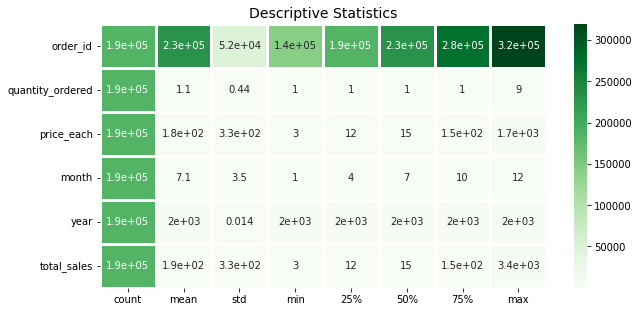

In [14]:
def desc_stats(dataframe):
    desc_df = pd.DataFrame(index = dataframe.columns, columns = dataframe.describe().T.columns, data = dataframe.describe().T)
    f,ax = plt.subplots(figsize= (10, desc_df.shape[0]*0.81))
    sns.heatmap(desc_df, annot = True, cmap = "Greens", linecolor= "white", linewidths= 1.1)
    plt.title("Descriptive Statistics", size = 14)
    plt.show()
desc_stats(df.select_dtypes(include = ['float','int']))

**Exploratory Data Analysis**

<AxesSubplot: >

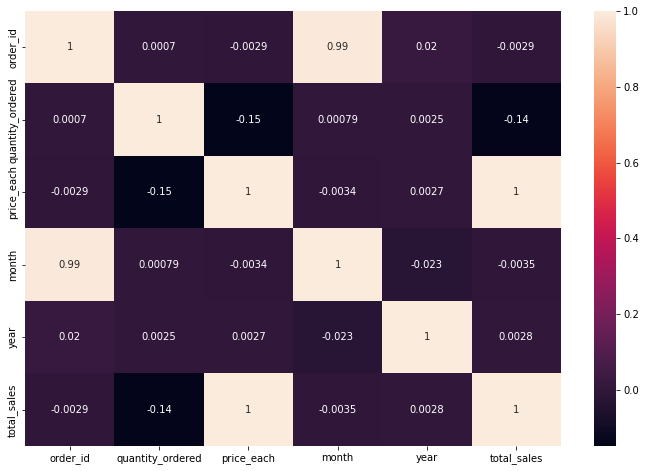

In [15]:
#correlation matrix and heatmap
figure = plt.figure(figsize= (12,8))
sns.heatmap(df.corr(), annot = True)

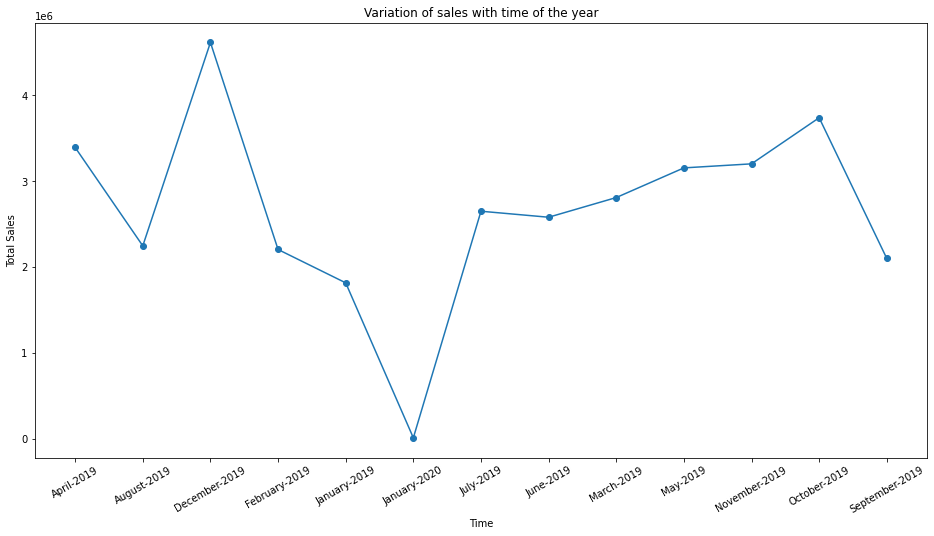

In [16]:
#change of sales with time
total_sales = df.groupby('month_year')['total_sales'].sum()
figure = plt.figure(figsize= (16,8))
plt.plot(total_sales, marker = "o")
plt.title("Variation of sales with time of the year")
plt.xticks(rotation = 30)
plt.xlabel('Time')
plt.ylabel('Total Sales')
plt.show()

<AxesSubplot: xlabel='count', ylabel='purchase_city'>

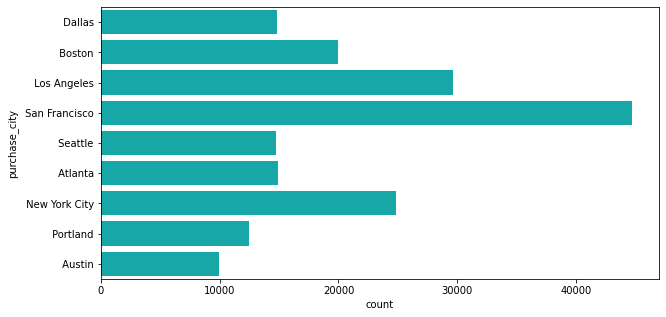

In [17]:
#understanding the cities in demand
plt.figure(figsize=(10,5))
sns.countplot(y = 'purchase_city', data = df, color ="c")

**Outlier Detection**

<AxesSubplot: xlabel='price_each', ylabel='Density'>

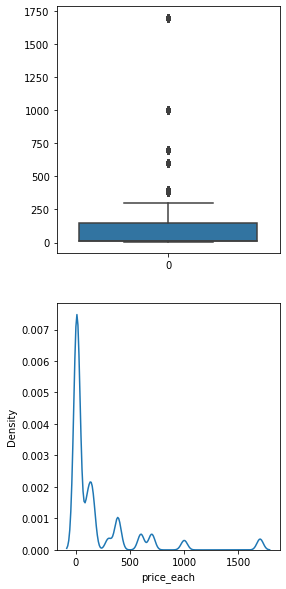

In [18]:
#boxplots for the detection of outliers in the data
plt.figure(figsize= (4,10))
plt.subplot(211)
sns.boxplot(df['price_each'])
plt.subplot(212)
sns.kdeplot(df['price_each'])

Lets quantify the amount of outliers present in the data

In [19]:
#IQR method
Q1 = np.percentile(df['price_each'], 25)
Q3 = np.percentile(df['price_each'], 75)
IQR = Q3-Q1 
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR
outliers = df['price_each'][(df['price_each']> upper_bound)| (df['price_each'] < lower_bound)]

if len(outliers) == 0:
    print("There are no outliers in the data")
else:
    print("The number of outliers that are present in the data are : ", len(outliers))

The number of outliers that are present in the data are :  37007


In [36]:
#using z_scores for the detection of outliers
#but since the data in the price_each columns is not normally distributed, there it may be not very accurate in this particular data
skewness = df['price_each'].skew()
z_scores = np.abs((df['price_each'] - df['price_each'].mean())/df['price_each'].std())
threshold = 3
outliers_2 = np.where(df['price_each'] > 3)
if len(outliers_2) == 0:
    print("There are no outliers in the data")
else:
    print("The number of outliers in the data are : " , len(outliers_2))


The number of outliers in the data are :  1


Since, the data is not normally distributed, hence it would be wise to go with the IQR test rather than that of z_score as the assumption of z_score is that the data should be normally distributed (which is not the case in this particular data).

In [21]:
print("The percentage of outliers in the data is :", round((len(outliers)/df.shape[0]) * 100,2), "%")

The percentage of outliers in the data is : 19.9 %


Since the number of outliers in the data as per the data is ~20%, therefore transforming and manipulating the data in that particular column could even alter the later models and the conclusions that can be driven from it. Therefore it would be better if the outliers in the data for this particular use case. 

## RFM Analysis ##

RFM stands for Recency, Frequency, and Monetary value, each corresponding to some key customer trait. These RFM metrics are important indicators of a customer’s behavior because frequency and monetary value affects a customer’s lifetime value, and recency affects retention, a measure of engagement.

RFM factors illustrate these facts:

- The more recent the purchase, the more responsive the customer is to promotions
- The more frequently the customer buys, the more engaged and satisfied they are
- Monetary value differentiates heavy spenders from low-value purchasers

But in order to perform RFM Analysis, it is necessary for us to have an unique identifier based on the customers and not on the basis of orders. Since we dont have the unique customer identifier in the data and hence we would derive the same based on the address from which the order were made. This is how we would try to segment the customer rather than the orders.
Although we can also perform order segmentation, but it wont make much sense to do so. Customer segmentation is something that we are trying to aiming for in this particular project and exercise.

- But before, the customer_ids are made, it is also important for us to keep a track on the consistencies in the address column so that we wont designate a different customer_id to a same customer.

In [22]:
df.head()

,order_id,product,quantity_ordered,price_each,order_date,purchase_address,month,year,month_year,purchase_city,category,total_sales
0,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",4,2019,April-2019,Dallas,Cable,24.0
2,176559,Bose SoundSport Headphones,1,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",4,2019,April-2019,Boston,Headphones,100.0
3,176560,Google Phone,1,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,2019,April-2019,Los Angeles,Phones,600.0
4,176560,Wired Headphones,1,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,2019,April-2019,Los Angeles,Headphones,12.0
5,176561,Wired Headphones,1,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",4,2019,April-2019,Los Angeles,Headphones,12.0


In [23]:
df['order_id'].value_counts()

160873    5
178158    4
277875    4
196615    4
304802    4
         ..
158177    1
158178    1
158179    1
158180    1
259357    1
Name: order_id, Length: 178437, dtype: int64

In [24]:
df.loc[df['order_id'] == 178158]

,order_id,product,quantity_ordered,price_each,order_date,purchase_address,month,year,month_year,purchase_city,category,total_sales
1681,178158,Google Phone,1,600.00,2019-04-28 21:13:00,"197 Center St, San Francisco, CA 94016",4,2019,April-2019,San Francisco,Phones,600.0
1682,178158,USB-C Charging Cable,1,11.95,2019-04-28 21:13:00,"197 Center St, San Francisco, CA 94016",4,2019,April-2019,San Francisco,Cable,12.0
1683,178158,Wired Headphones,1,11.99,2019-04-28 21:13:00,"197 Center St, San Francisco, CA 94016",4,2019,April-2019,San Francisco,Headphones,12.0
1684,178158,USB-C Charging Cable,1,11.95,2019-04-28 21:13:00,"197 Center St, San Francisco, CA 94016",4,2019,April-2019,San Francisco,Cable,12.0


In [25]:
df.loc[df['purchase_address'] == "197 Center St, San Francisco, CA 94016"]

,order_id,product,quantity_ordered,price_each,order_date,purchase_address,month,year,month_year,purchase_city,category,total_sales
1681,178158,Google Phone,1,600.00,2019-04-28 21:13:00,"197 Center St, San Francisco, CA 94016",4,2019,April-2019,San Francisco,Phones,600.0
1682,178158,USB-C Charging Cable,1,11.95,2019-04-28 21:13:00,"197 Center St, San Francisco, CA 94016",4,2019,April-2019,San Francisco,Cable,12.0
1683,178158,Wired Headphones,1,11.99,2019-04-28 21:13:00,"197 Center St, San Francisco, CA 94016",4,2019,April-2019,San Francisco,Headphones,12.0
1684,178158,USB-C Charging Cable,1,11.95,2019-04-28 21:13:00,"197 Center St, San Francisco, CA 94016",4,2019,April-2019,San Francisco,Cable,12.0
78154,223758,Wired Headphones,1,11.99,2019-07-13 17:31:00,"197 Center St, San Francisco, CA 94016",7,2019,July-2019,San Francisco,Headphones,12.0
78155,223758,AA Batteries (4-pack),2,3.84,2019-07-13 17:31:00,"197 Center St, San Francisco, CA 94016",7,2019,July-2019,San Francisco,Batteries,8.0
178346,251204,Google Phone,1,600.00,2019-09-13 20:02:00,"197 Center St, San Francisco, CA 94016",9,2019,September-2019,San Francisco,Phones,600.0


From the above check made, it can be figured out that the customer identifier according to this particular data will be the address from which the order is made.

In [26]:
#deriving an unique identifier based on the address
df['customer_id'] = df.groupby('purchase_address').ngroup()
df.head()

,order_id,product,quantity_ordered,price_each,order_date,purchase_address,month,year,month_year,purchase_city,category,total_sales,customer_id
0,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",4,2019,April-2019,Dallas,Cable,24.0,127920
2,176559,Bose SoundSport Headphones,1,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",4,2019,April-2019,Boston,Headphones,100.0,91286
3,176560,Google Phone,1,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,2019,April-2019,Los Angeles,Phones,600.0,89198
4,176560,Wired Headphones,1,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,2019,April-2019,Los Angeles,Headphones,12.0,89198
5,176561,Wired Headphones,1,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",4,2019,April-2019,Los Angeles,Headphones,12.0,36625


In [27]:
#checking if the above code worked or not
df.loc[df['purchase_address'] == "197 Center St, San Francisco, CA 94016"]

,order_id,product,quantity_ordered,price_each,order_date,purchase_address,month,year,month_year,purchase_city,category,total_sales,customer_id
1681,178158,Google Phone,1,600.00,2019-04-28 21:13:00,"197 Center St, San Francisco, CA 94016",4,2019,April-2019,San Francisco,Phones,600.0,15305
1682,178158,USB-C Charging Cable,1,11.95,2019-04-28 21:13:00,"197 Center St, San Francisco, CA 94016",4,2019,April-2019,San Francisco,Cable,12.0,15305
1683,178158,Wired Headphones,1,11.99,2019-04-28 21:13:00,"197 Center St, San Francisco, CA 94016",4,2019,April-2019,San Francisco,Headphones,12.0,15305
1684,178158,USB-C Charging Cable,1,11.95,2019-04-28 21:13:00,"197 Center St, San Francisco, CA 94016",4,2019,April-2019,San Francisco,Cable,12.0,15305
78154,223758,Wired Headphones,1,11.99,2019-07-13 17:31:00,"197 Center St, San Francisco, CA 94016",7,2019,July-2019,San Francisco,Headphones,12.0,15305
78155,223758,AA Batteries (4-pack),2,3.84,2019-07-13 17:31:00,"197 Center St, San Francisco, CA 94016",7,2019,July-2019,San Francisco,Batteries,8.0,15305
178346,251204,Google Phone,1,600.00,2019-09-13 20:02:00,"197 Center St, San Francisco, CA 94016",9,2019,September-2019,San Francisco,Phones,600.0,15305


In [28]:
#the code can also be verified using the logic if the count unique addresses in the data is same as that of the count of 
#unique customer_ids that are assigned

print("The number of unique addresses in the data are : ", df['purchase_address'].nunique(), " and the number of unique customer_ids are: ", df['customer_id'].nunique())

The number of unique addresses in the data are :  140787  and the number of unique customer_ids are:  140787


Hence the logic worked

In [29]:
df.head()

,order_id,product,quantity_ordered,price_each,order_date,purchase_address,month,year,month_year,purchase_city,category,total_sales,customer_id
0,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",4,2019,April-2019,Dallas,Cable,24.0,127920
2,176559,Bose SoundSport Headphones,1,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",4,2019,April-2019,Boston,Headphones,100.0,91286
3,176560,Google Phone,1,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,2019,April-2019,Los Angeles,Phones,600.0,89198
4,176560,Wired Headphones,1,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,2019,April-2019,Los Angeles,Headphones,12.0,89198
5,176561,Wired Headphones,1,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",4,2019,April-2019,Los Angeles,Headphones,12.0,36625


In [30]:
print(df['order_date'].max())

2020-01-01 05:13:00


In [31]:
#RFM metrics
current_date = dt.datetime(2023,4,20)
rfm_df = pd.DataFrame(df.groupby('customer_id').agg({'order_date': lambda x: (current_date - x.max()).days,
                                                     'order_id': lambda x: x.nunique(),
                                                     'total_sales': lambda x: x.sum()}))
rfm_df.columns = ['recency', 'frequency', 'monetory']
# rfm_df['monetory'] = rfm_df[rfm_df['monetory'] > 0]
rfm_df = rfm_df.reset_index()
rfm_df.head()

,customer_id,recency,frequency,monetory
0,0,1497,1,12.0
1,1,1276,1,1700.0
2,2,1314,1,700.0
3,3,1492,1,150.0
4,4,1271,1,12.0


In [32]:
#getting the rfm scores for the above derived table by dividing them into specific quantiles of data
rfm_df['r_quartiles'] = pd.qcut(rfm_df['recency'], 4, labels = False)
rfm_df['f_quartiles'] = pd.qcut(rfm_df['frequency'], 7, labels = False, duplicates= 'drop')
rfm_df['m_quartiles'] = pd.qcut(rfm_df['monetory'], 4, labels = False)

#concatenating these values in the dataframe that is creating for rfm
rfm_df.rename(columns = {'r_quartiles':'R','f_quartiles':'F','m_quartiles':'M'}, inplace = True)


#creating a function for concatenating the quartiles that are derived
def rfm_scores(row):
    return str(row['R']) + str(row['F']) + str(row['M'])
rfm_df['rfm_group'] = rfm_df.apply(rfm_scores, axis = 1)

#create the concatenated columns for segmentation
columns = ['R','F','M']
for i in columns:
    rfm_df[i] = rfm_df[i].astype(str)
rfm_df['rfm_group'] = rfm_df['R'] + rfm_df['F'] + rfm_df['M']
rfm_df.head()

,customer_id,recency,frequency,monetory,R,F,M,rfm_group
0,0,1497,1,12.0,3,0,0,300
1,1,1276,1,1700.0,1,0,3,103
2,2,1314,1,700.0,1,0,3,103
3,3,1492,1,150.0,3,0,2,302
4,4,1271,1,12.0,1,0,0,100


In [33]:
#categorising the customer and the attention that they need from the rfm_groups that are created
group_values = {'313' : 'Best customer',
'312' : 'Satisfied customer / Spends money',
'311' : 'Satisfied customer / Spends money',
'310' : 'Satisfied customer / No Money spent',
'303' : 'Potential customers',
'302' : 'Potential customers',
'301' : 'Potential customers',
'300' : 'Potential customers',
'213' : 'Potential customers',
'212' : 'Potential customers',
'211' : 'Potential customers',
'210' : 'Try ads to win them back',
'203' : 'Try ads to win them back',
'202' : 'Try ads to win them back',
'201' : 'Try ads to win them back',
'200' : 'Try ads to win them back',
'113' : 'Potential customers',
'112' : 'Can spend money, try giving him/her more offers',
'111' : 'Customer Hibernation',
'110' : 'Customer Hibernation',
'103' : 'Can spend money, try giving him/her more offers',
'102' : 'Customer Hibernation',
'101' : 'Customer Hibernation',
'100' : 'Customer Hibernation',
'013' : 'Can spend money, try giving him/her more offers',
'012' : 'Can spend money, try giving him/her more offers',
'011' : 'New customers',
'010' : 'New customers',
'003' : 'New customers',
'002' : 'New customers',
'001' : 'New customers',
'000' : 'New customers'}

rfm_df['segments'] = rfm_df['rfm_group'].map(group_values)
rfm_df.head()

,customer_id,recency,frequency,monetory,R,F,M,rfm_group,segments
0,0,1497,1,12.0,3,0,0,300,Potential customers
1,1,1276,1,1700.0,1,0,3,103,"Can spend money, try giving him/her more offers"
2,2,1314,1,700.0,1,0,3,103,"Can spend money, try giving him/her more offers"
3,3,1492,1,150.0,3,0,2,302,Potential customers
4,4,1271,1,12.0,1,0,0,100,Customer Hibernation


In [34]:
rfm_df.segments.value_counts()

Potential customers                                36821
Try ads to win them back                           34235
New customers                                      33080
Customer Hibernation                               26139
Can spend money, try giving him/her more offers    10383
Best customer                                         74
Satisfied customer / Spends money                     53
Satisfied customer / No Money spent                    2
Name: segments, dtype: int64

<AxesSubplot: xlabel='count', ylabel='segments'>

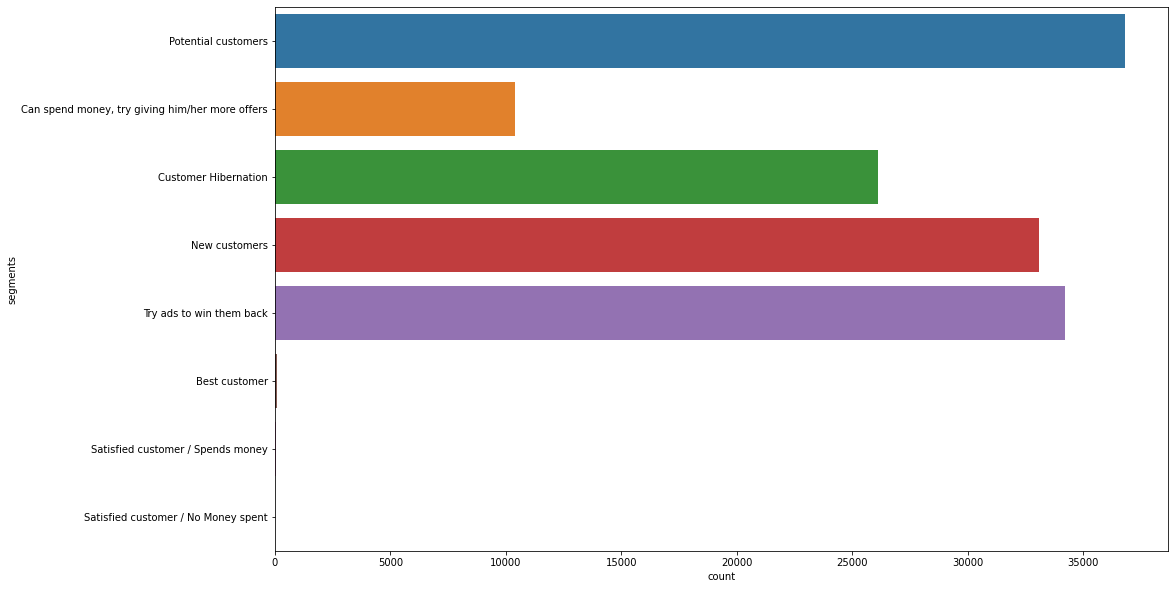

In [35]:
#Understanding the count of the customers in each segments
figure = plt.figure(figsize = (16,10))
sns.countplot(y = 'segments', data = rfm_df)

**Segment Validation**

In [38]:
x = rfm_df[['R','F']]
labels = rfm_df['segments']
print(f' RFM Model Evaluation '.center(70,'='))
print(f'The number of observations present in the data are : ', df.shape[0])
print(f'The number of customer segments made are : ', labels.nunique())
print(f'Silhouette Score: {round(silhouette_score(x, labels), 3)}')
print(f'Calinski Harabasz Score: {round(calinski_harabasz_score(x, labels), 3)}')
print(f'Davies Bouldin Score: {round(davies_bouldin_score(x, labels), 3)} \n{70*"="}')

=========================RFM Model Evaluation=========================
The number of observations present in the data are :  185950
The number of customer segments made are :  8
Silhouette Score: 0.82
Calinski Harabasz Score: 308905.056
Davies Bouldin Score: 0.663 


## Understanding the variation of sales with respect to Time ##

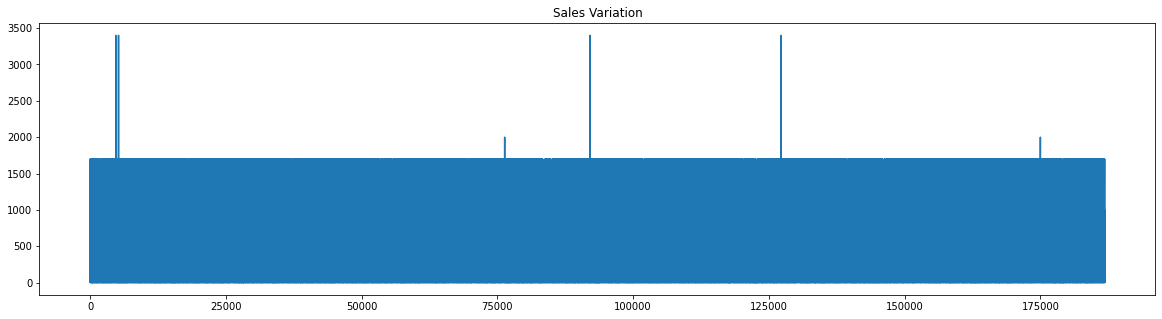

In [58]:
#understanding the variation of total sales with respect to time
df['total_sales'].plot(figsize = (20,5),title = 'Sales Variation', kind = 'line')
plt.show()

In [42]:
df.head()

,order_id,product,quantity_ordered,price_each,order_date,purchase_address,month,year,month_year,purchase_city,category,total_sales,customer_id
0,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",4,2019,April-2019,Dallas,Cable,24.0,127920
2,176559,Bose SoundSport Headphones,1,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",4,2019,April-2019,Boston,Headphones,100.0,91286
3,176560,Google Phone,1,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,2019,April-2019,Los Angeles,Phones,600.0,89198
4,176560,Wired Headphones,1,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,2019,April-2019,Los Angeles,Headphones,12.0,89198
5,176561,Wired Headphones,1,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",4,2019,April-2019,Los Angeles,Headphones,12.0,36625


<AxesSubplot: title={'center': 'Sales variation with date'}, xlabel='month_year'>

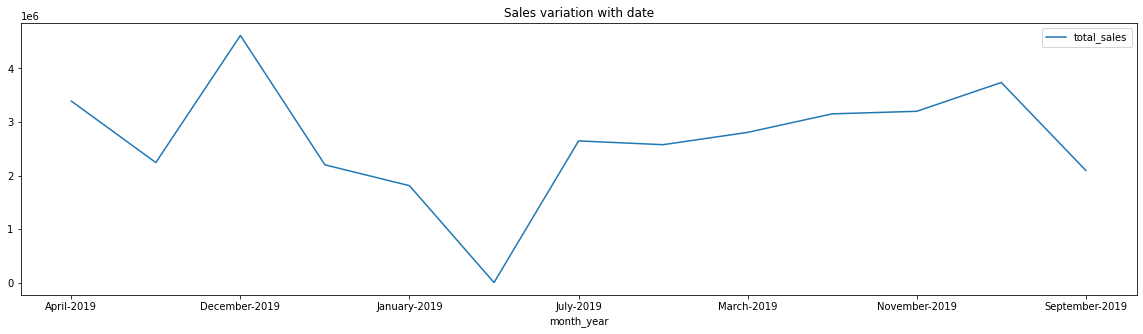

In [50]:
df_time = pd.DataFrame(df.groupby('month_year')['total_sales'].sum())
df_time.reset_index()
df_time.plot(figsize = (20,5), title = 'Sales variation with date')

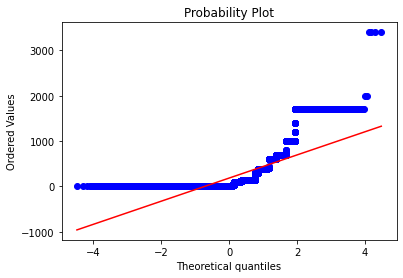

In [54]:
#the qq plot
scipy.stats.probplot(df['total_sales'], plot = pylab)
pylab.show()

#the x axis represents how many values are away from the standard deviation of the values
#the red diagonal line represents what the data should follow if they are normally distributed.